In [83]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
nltk.download('punkt')  # Untuk tokenisasi kata
nltk.download('stopwords')  # Untuk daftar stopwords
nltk.download('punkt_tab')
nltk.data.path.append('/root/nltk_data')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [84]:
# Load Dataset
file_path = "/content/youtube_comments-20250301_022205.csv"
df = pd.read_csv(file_path)

In [85]:
# Drop missing values
df.dropna(subset=['content'], inplace=True)

# Text Preprocessing
def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

df['cleaned_content'] = df['content'].apply(clean_text)

In [86]:
# Sentiment Labeling using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['cleaned_content'].apply(get_sentiment)
print(df['sentiment'].value_counts())

sentiment
neutral     2066
positive     670
negative     264
Name: count, dtype: int64


In [87]:
# Feature Extraction (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(df['cleaned_content'])
y = df['sentiment']

In [88]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())

sentiment
neutral     1653
positive    1653
negative    1653
Name: count, dtype: int64


In [89]:
# Model Training & Evaluation
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

Naive Bayes Accuracy: 0.7717
              precision    recall  f1-score   support

    negative       1.00      0.05      0.10        60
     neutral       0.76      1.00      0.86       413
    positive       0.92      0.37      0.53       127

    accuracy                           0.77       600
   macro avg       0.89      0.47      0.49       600
weighted avg       0.82      0.77      0.71       600

SVM Accuracy: 0.8550
              precision    recall  f1-score   support

    negative       0.93      0.42      0.57        60
     neutral       0.84      0.99      0.91       413
    positive       0.92      0.61      0.74       127

    accuracy                           0.85       600
   macro avg       0.89      0.67      0.74       600
weighted avg       0.87      0.85      0.84       600

Random Forest Accuracy: 0.8867
              precision    recall  f1-score   support

    negative       0.97      0.55      0.70        60
     neutral       0.88      1.00      0.93     

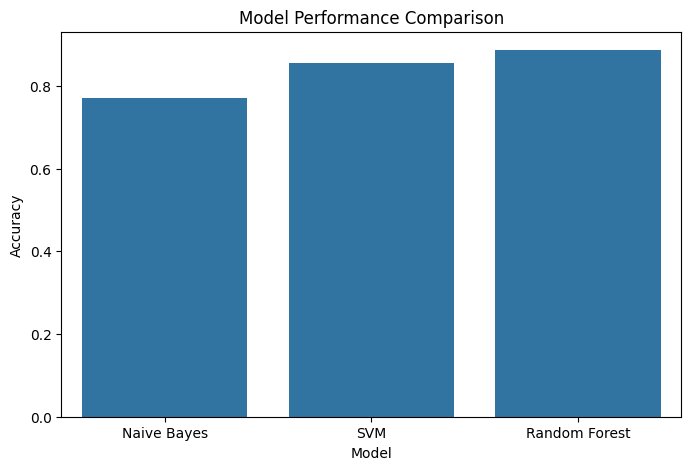

In [90]:
# Visualizing Performance
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.show()

In [91]:
# Dictionary untuk menyimpan hasil akurasi training dan testing
train_results = {}
test_results = {}

# Evaluasi model pada training dan testing set
for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Hitung akurasi
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Simpan hasil
    train_results[name] = accuracy_train
    test_results[name] = accuracy_test

    # Tampilkan hasil akurasi
    print(f"{name} - Training Accuracy: {accuracy_train:.4f}")
    print(f"{name} - Testing Accuracy: {accuracy_test:.4f}")

Naive Bayes - Training Accuracy: 0.8483
Naive Bayes - Testing Accuracy: 0.7717
SVM - Training Accuracy: 0.9854
SVM - Testing Accuracy: 0.8550
Random Forest - Training Accuracy: 1.0000
Random Forest - Testing Accuracy: 0.8867


In [92]:
new_sentences = ["this app is very shit", "very useful application", "the app is quite good"]

new_cleaned = [clean_text(text) for text in new_sentences]

new_tfidf = tfidf_vectorizer.transform(new_cleaned)

best_model = models['Random Forest']

predictions = best_model.predict(new_tfidf)

for sentence, label in zip(new_sentences, predictions):
    print(f'Sentence: "{sentence}" - Predicted Label: {label}')

Sentence: "this app is very shit" - Predicted Label: negative
Sentence: "very useful application" - Predicted Label: neutral
Sentence: "the app is quite good" - Predicted Label: positive
